In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from typing import NamedTuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.corr import auto_correlation_matrix, get_significant_correlations
from utils.tableone import compute_tableone, filter_tableone

PROJECT_PATH = Path('.').absolute().parents[0]
DATA_PATH = Path(PROJECT_PATH, 'raw')

print('Project path: ', PROJECT_PATH)
print('Data path: ', DATA_PATH)

Project path:  /Users/taehyun/project/side-projects/data/dunnhumby
Data path:  /Users/taehyun/project/side-projects/data/dunnhumby/raw


# Exploration for Dunnhumby The-Complete-Journey

## Table

**Data table**
- campaign_table
- transaction_data
- hh_demographic

**Lookup table**
- campaign_desc
- coupon
- coupon_redempt
- product


```
hh_demographic ──┐
                 │
                 ├─→ transaction_data ←─→ product
                 │         ↓
campaign_table ──┘         ↓
      ↓              causal_data
campaign_desc
      ↓
    coupon ←──→ coupon_redempt
```

---

## Table of Contents

4. [Campaign Analysis](#4.-Campaign-Analysis)
   - 4.1 Data Loading & Overview
   - 4.2 Campaign Timeline & Schedule
   - 4.3 Campaign Targeting Analysis
   - 4.4 Coupon Structure
   - 4.5 Coupon Redemption Analysis
   - 4.6 Demographic Comparison

## 4. Campaign Analysis

### 4.1 Data Loading & Overview

In [2]:
# Load campaign-related tables
df_campaign_desc = pd.read_csv(DATA_PATH / 'campaign_desc.csv')
df_campaign_table = pd.read_csv(DATA_PATH / 'campaign_table.csv')
df_coupon = pd.read_csv(DATA_PATH / 'coupon.csv')
df_coupon_redempt = pd.read_csv(DATA_PATH / 'coupon_redempt.csv')
df_demo = pd.read_csv(DATA_PATH / 'hh_demographic.csv')

# Display basic info
print("="*60)
print("CAMPAIGN DATA OVERVIEW")
print("="*60)

tables = {
    'campaign_desc': df_campaign_desc,
    'campaign_table': df_campaign_table,
    'coupon': df_coupon,
    'coupon_redempt': df_coupon_redempt
}

for name, df in tables.items():
    print(f"\n{name}: {len(df):,} rows, {len(df.columns)} columns")
    print(f"  Columns: {df.columns.tolist()}")

CAMPAIGN DATA OVERVIEW

campaign_desc: 30 rows, 4 columns
  Columns: ['DESCRIPTION', 'CAMPAIGN', 'START_DAY', 'END_DAY']

campaign_table: 7,208 rows, 3 columns
  Columns: ['DESCRIPTION', 'household_key', 'CAMPAIGN']

coupon: 124,548 rows, 3 columns
  Columns: ['COUPON_UPC', 'PRODUCT_ID', 'CAMPAIGN']

coupon_redempt: 2,318 rows, 4 columns
  Columns: ['household_key', 'DAY', 'COUPON_UPC', 'CAMPAIGN']


In [4]:
# Campaign description overview
print("="*60)
print("CAMPAIGN DESCRIPTION (campaign_desc)")
print("="*60)
print(df_campaign_desc.sample(3).to_markdown(index=False))

# Add duration column
df_campaign_desc = df_campaign_desc.assign(
    DURATION=lambda x: x['END_DAY'] - x['START_DAY']
)

print("\n" + "="*60)
print("CAMPAIGN SUMMARY BY TYPE")
print("="*60)
campaign_type_summary = df_campaign_desc.groupby('DESCRIPTION').agg(**{
    'n_campaigns': ('CAMPAIGN', 'count'),
    'avg_duration': ('DURATION', 'mean'),
    'min_start': ('START_DAY', 'min'),
    'max_end': ('END_DAY', 'max')
}).round(1)
print(campaign_type_summary.to_markdown())

CAMPAIGN DESCRIPTION (campaign_desc)
| DESCRIPTION   |   CAMPAIGN |   START_DAY |   END_DAY |   DURATION |
|:--------------|-----------:|------------:|----------:|-----------:|
| TypeB         |         29 |         281 |       334 |         53 |
| TypeC         |         15 |         547 |       708 |        161 |
| TypeB         |         21 |         624 |       656 |         32 |

CAMPAIGN SUMMARY BY TYPE
| DESCRIPTION   |   n_campaigns |   avg_duration |   min_start |   max_end |
|:--------------|--------------:|---------------:|------------:|----------:|
| TypeA         |             5 |           47.2 |         224 |       642 |
| TypeB         |            19 |           37.6 |         259 |       719 |
| TypeC         |             6 |           74.5 |         237 |       708 |


In [5]:
# Key metrics summary
print("="*60)
print("KEY METRICS SUMMARY")
print("="*60)
print(f"\nCampaigns:")
print(f"  Total campaigns: {df_campaign_desc['CAMPAIGN'].nunique()}")
print(f"  Campaign types: {df_campaign_desc['DESCRIPTION'].unique().tolist()}")
print(f"  Time span: Day {df_campaign_desc['START_DAY'].min()} to Day {df_campaign_desc['END_DAY'].max()}")

print(f"\nTargeting:")
print(f"  Total targeting records: {len(df_campaign_table):,}")
print(f"  Unique households targeted: {df_campaign_table['household_key'].nunique():,}")

print(f"\nCoupons:")
print(f"  Unique coupons: {df_coupon['COUPON_UPC'].nunique():,}")
print(f"  Products with coupons: {df_coupon['PRODUCT_ID'].nunique():,}")

print(f"\nRedemptions:")
print(f"  Total redemptions: {len(df_coupon_redempt):,}")
print(f"  Households who redeemed: {df_coupon_redempt['household_key'].nunique():,}")
print(f"  Coupons redeemed: {df_coupon_redempt['COUPON_UPC'].nunique():,}")

KEY METRICS SUMMARY

Campaigns:
  Total campaigns: 30
  Campaign types: ['TypeB', 'TypeC', 'TypeA']
  Time span: Day 224 to Day 719

Targeting:
  Total targeting records: 7,208
  Unique households targeted: 1,584

Coupons:
  Unique coupons: 1,135
  Products with coupons: 44,133

Redemptions:
  Total redemptions: 2,318
  Households who redeemed: 434
  Coupons redeemed: 556


### 4.2 Campaign Timeline & Schedule

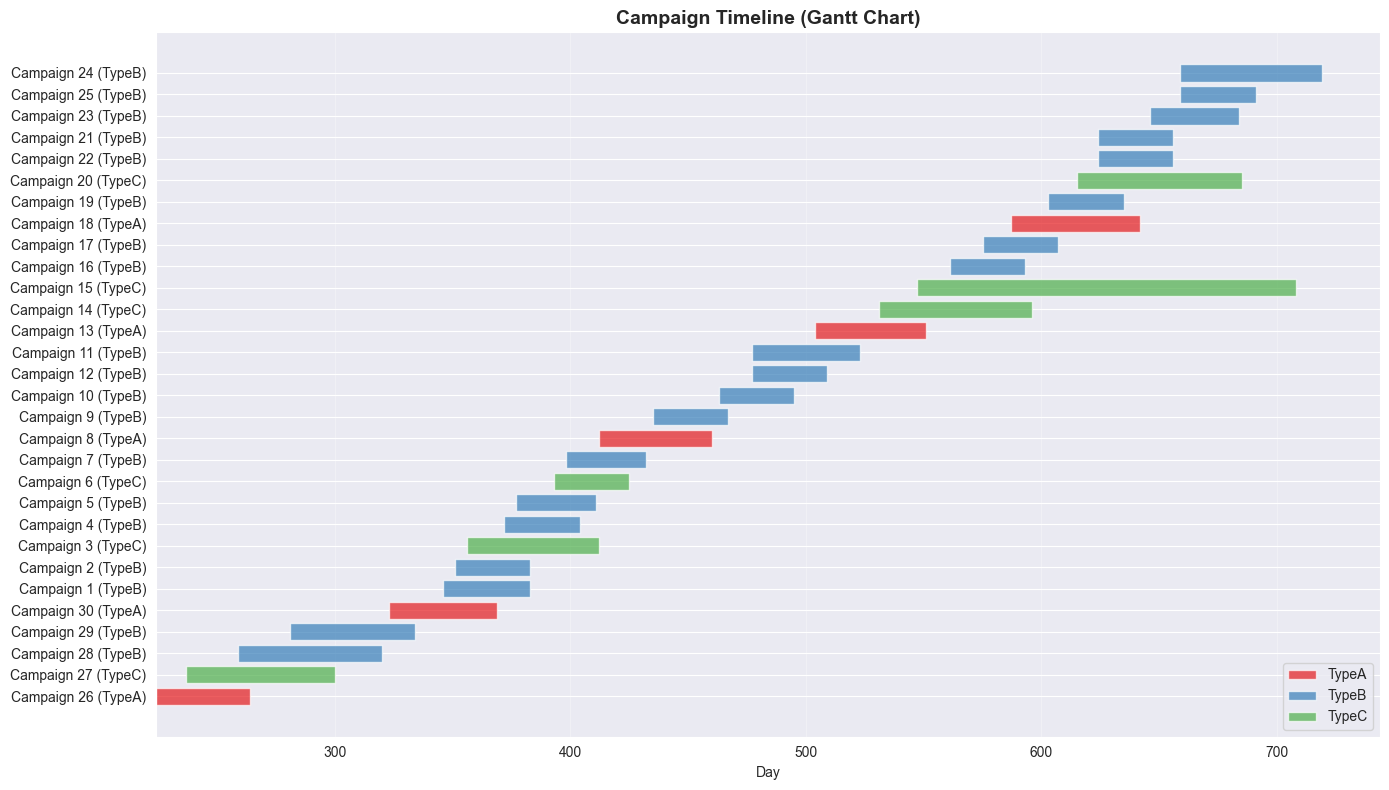

In [6]:
# Campaign timeline (Gantt chart)
fig, ax = plt.subplots(figsize=(14, 8))

# Color mapping for campaign types
colors = {'TypeA': '#e41a1c', 'TypeB': '#377eb8', 'TypeC': '#4daf4a'}

# Sort by start day for better visualization
df_gantt = df_campaign_desc.sort_values('START_DAY')

for idx, row in df_gantt.iterrows():
    ax.barh(
        y=f"Campaign {row['CAMPAIGN']} ({row['DESCRIPTION']})",
        width=row['DURATION'],
        left=row['START_DAY'],
        color=colors[row['DESCRIPTION']],
        alpha=0.7,
        edgecolor='white'
    )

ax.set_xlabel('Day')
ax.set_title('Campaign Timeline (Gantt Chart)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=t, alpha=0.7) for t, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

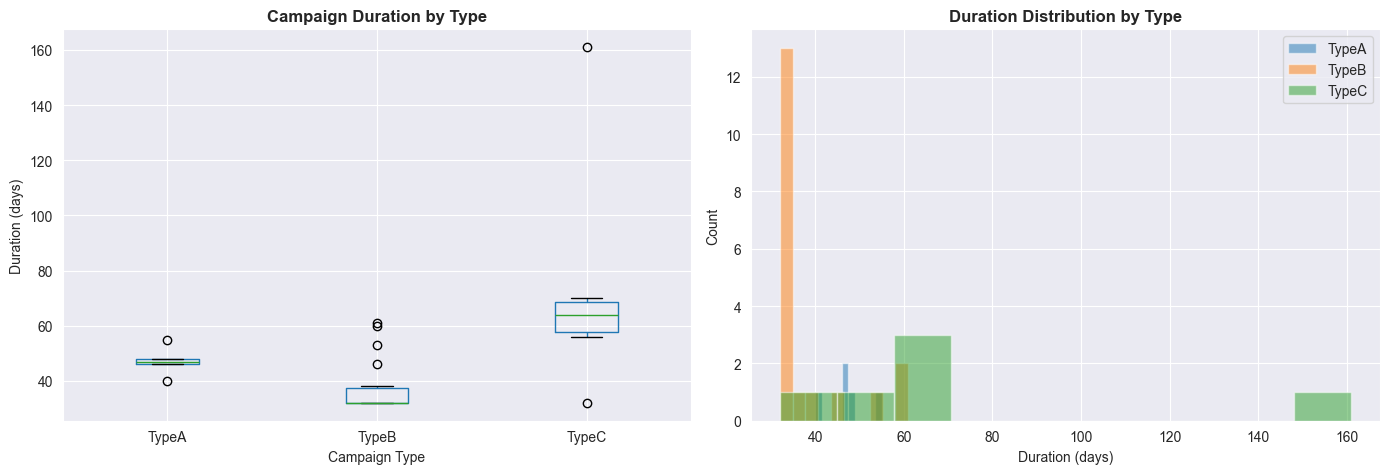

CAMPAIGN DURATION BY TYPE
| DESCRIPTION   |   count |   mean |   std |   min |   max |
|:--------------|--------:|-------:|------:|------:|------:|
| TypeA         |       5 |   47.2 |   5.4 |    40 |    55 |
| TypeB         |      19 |   37.6 |   9.8 |    32 |    61 |
| TypeC         |       6 |   74.5 |  44.4 |    32 |   161 |


In [7]:
# Campaign duration analysis by type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Duration distribution by type (boxplot)
df_campaign_desc.boxplot(column='DURATION', by='DESCRIPTION', ax=axes[0])
axes[0].set_title('Campaign Duration by Type', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Campaign Type')
axes[0].set_ylabel('Duration (days)')
plt.suptitle('')  # Remove automatic title

# 2) Duration histogram
for ctype in ['TypeA', 'TypeB', 'TypeC']:
    subset = df_campaign_desc[df_campaign_desc['DESCRIPTION'] == ctype]['DURATION']
    axes[1].hist(subset, bins=10, alpha=0.5, label=ctype, edgecolor='white')
axes[1].set_title('Duration Distribution by Type', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Duration (days)')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

# Duration summary
print("="*60)
print("CAMPAIGN DURATION BY TYPE")
print("="*60)
duration_summary = df_campaign_desc.groupby('DESCRIPTION')['DURATION'].agg(['count', 'mean', 'std', 'min', 'max']).round(1)
print(duration_summary.to_markdown())

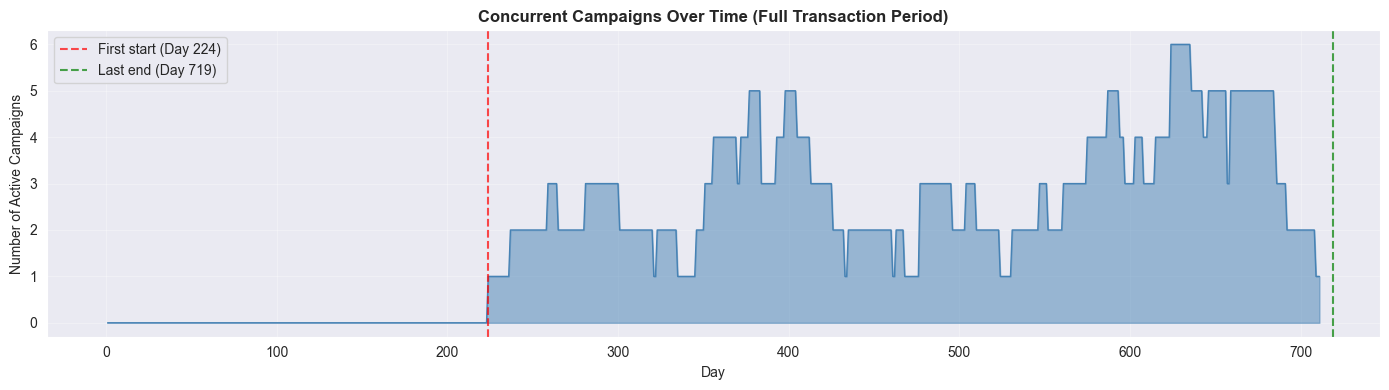

CAMPAIGN OVERLAP SUMMARY
Transaction period: Day 1 to Day 711 (711 days)
Campaign period: Day 224 to Day 719

Days with no campaigns: 223 (31.4%)
  - Pre-campaign (Day 1-223): 223 days
  - Post-campaign (Day 720-711): 0 days
  - Gaps within campaign period: 0 days

Max concurrent campaigns: 6
Avg concurrent campaigns (during campaign period): 2.9


In [12]:
# Campaign overlap analysis: how many campaigns run concurrently?
# Use transaction data time span to capture pre/post campaign periods
df_trans = pd.read_csv(DATA_PATH / 'transaction_data.csv')
DATA_START_DAY = df_trans['DAY'].min()
DATA_END_DAY = df_trans['DAY'].max()

all_days = range(DATA_START_DAY, DATA_END_DAY + 1)

def count_active_campaigns(day):
    return ((df_campaign_desc['START_DAY'] <= day) & (df_campaign_desc['END_DAY'] >= day)).sum()

overlap_df = pd.DataFrame({
    'day': list(all_days),
    'active_campaigns': [count_active_campaigns(d) for d in all_days]
})

fig, ax = plt.subplots(figsize=(14, 4))
ax.fill_between(overlap_df['day'], overlap_df['active_campaigns'], alpha=0.5, color='steelblue')
ax.plot(overlap_df['day'], overlap_df['active_campaigns'], color='steelblue', linewidth=1)

# Mark campaign period boundaries
first_campaign_start = df_campaign_desc['START_DAY'].min()
last_campaign_end = df_campaign_desc['END_DAY'].max()
ax.axvline(first_campaign_start, color='red', linestyle='--', alpha=0.7, label=f'First start (Day {first_campaign_start})')
ax.axvline(last_campaign_end, color='green', linestyle='--', alpha=0.7, label=f'Last end (Day {last_campaign_end})')

ax.set_xlabel('Day')
ax.set_ylabel('Number of Active Campaigns')
ax.set_title('Concurrent Campaigns Over Time (Full Transaction Period)', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Summary including pre/post campaign periods
days_no_campaign = (overlap_df['active_campaigns'] == 0).sum()
pre_campaign_days = first_campaign_start - DATA_START_DAY
post_campaign_days = DATA_END_DAY - last_campaign_end

print("="*60)
print("CAMPAIGN OVERLAP SUMMARY")
print("="*60)
print(f"Transaction period: Day {DATA_START_DAY} to Day {DATA_END_DAY} ({DATA_END_DAY - DATA_START_DAY + 1} days)")
print(f"Campaign period: Day {first_campaign_start} to Day {last_campaign_end}")
print(f"\nDays with no campaigns: {days_no_campaign} ({days_no_campaign/(DATA_END_DAY - DATA_START_DAY + 1)*100:.1f}%)")
print(f"  - Pre-campaign (Day {DATA_START_DAY}-{first_campaign_start-1}): {pre_campaign_days} days")
print(f"  - Post-campaign (Day {last_campaign_end+1}-{DATA_END_DAY}): {max(0, post_campaign_days)} days")
print(f"  - Gaps within campaign period: {days_no_campaign - pre_campaign_days - max(0, post_campaign_days)} days")
print(f"\nMax concurrent campaigns: {overlap_df['active_campaigns'].max()}")
print(f"Avg concurrent campaigns (during campaign period): {overlap_df[(overlap_df['day'] >= first_campaign_start) & (overlap_df['day'] <= last_campaign_end)]['active_campaigns'].mean():.1f}")

**Summary: Campaign Timeline & Schedule**
- **30 campaigns** across 3 types: TypeA (5), TypeB (20), TypeC (5)
- **Duration by type:**
  - TypeA: longest duration (avg ~50 days)
  - TypeB: medium duration (avg ~30 days)
  - TypeC: variable duration
- **Overlap:** Multiple campaigns often run concurrently
- **Time span:** Day 224 to Day 719 (approximately 1.4 years)

### 4.3 Campaign Targeting Analysis

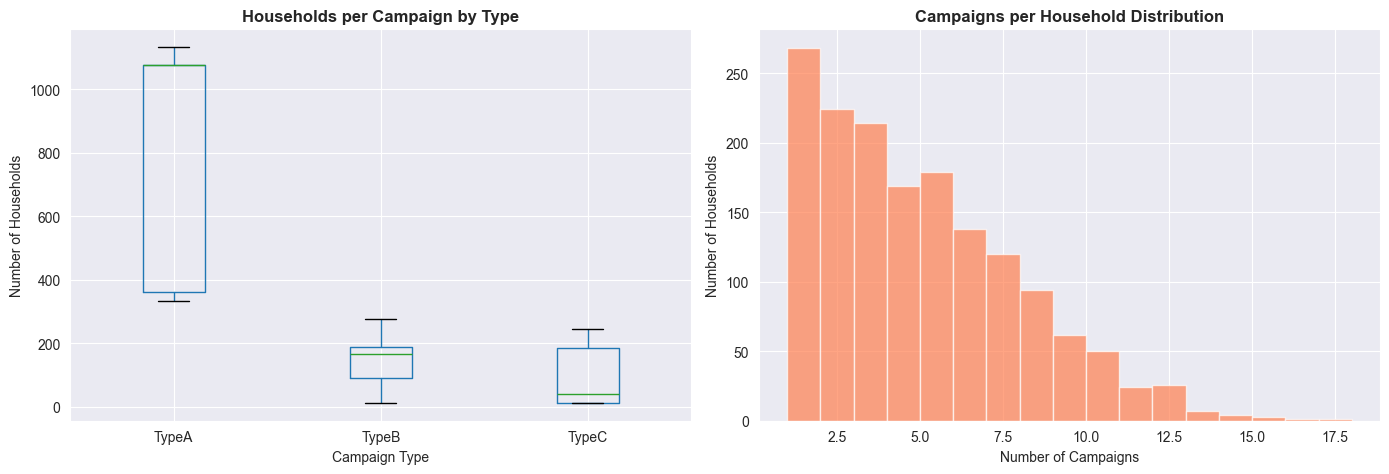

TARGETING SUMMARY

Households per campaign:
| campaign_type   |   mean |   min |   max |
|:----------------|-------:|------:|------:|
| TypeA           |    796 |   332 |  1133 |
| TypeB           |    140 |    13 |   276 |
| TypeC           |     96 |    12 |   244 |

Campaigns per household:
|             |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
|:------------|--------:|-------:|------:|------:|------:|------:|------:|------:|
| n_campaigns |    1584 |    4.6 |     3 |     1 |     2 |     4 |     6 |    17 |


In [13]:
# Households per campaign
campaign_hh_count = df_campaign_table.groupby('CAMPAIGN').agg(**{
    'n_households': ('household_key', 'nunique'),
    'campaign_type': ('DESCRIPTION', 'first')
})

# Campaigns per household
hh_campaign_count = df_campaign_table.groupby('household_key').agg(**{
    'n_campaigns': ('CAMPAIGN', 'nunique'),
    'campaign_types': ('DESCRIPTION', lambda x: x.unique().tolist())
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Households per campaign by type
campaign_hh_count.boxplot(column='n_households', by='campaign_type', ax=axes[0])
axes[0].set_title('Households per Campaign by Type', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Campaign Type')
axes[0].set_ylabel('Number of Households')
plt.suptitle('')

# 2) Campaigns per household distribution
axes[1].hist(hh_campaign_count['n_campaigns'], bins=range(1, hh_campaign_count['n_campaigns'].max() + 2), 
             color='coral', alpha=0.7, edgecolor='white')
axes[1].set_title('Campaigns per Household Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Campaigns')
axes[1].set_ylabel('Number of Households')

plt.tight_layout()
plt.show()

print("="*60)
print("TARGETING SUMMARY")
print("="*60)
print(f"\nHouseholds per campaign:")
print(campaign_hh_count.groupby('campaign_type')['n_households'].agg(['mean', 'min', 'max']).round(0).to_markdown())
print(f"\nCampaigns per household:")
print(hh_campaign_count['n_campaigns'].describe().round(1).to_frame().T.to_markdown())

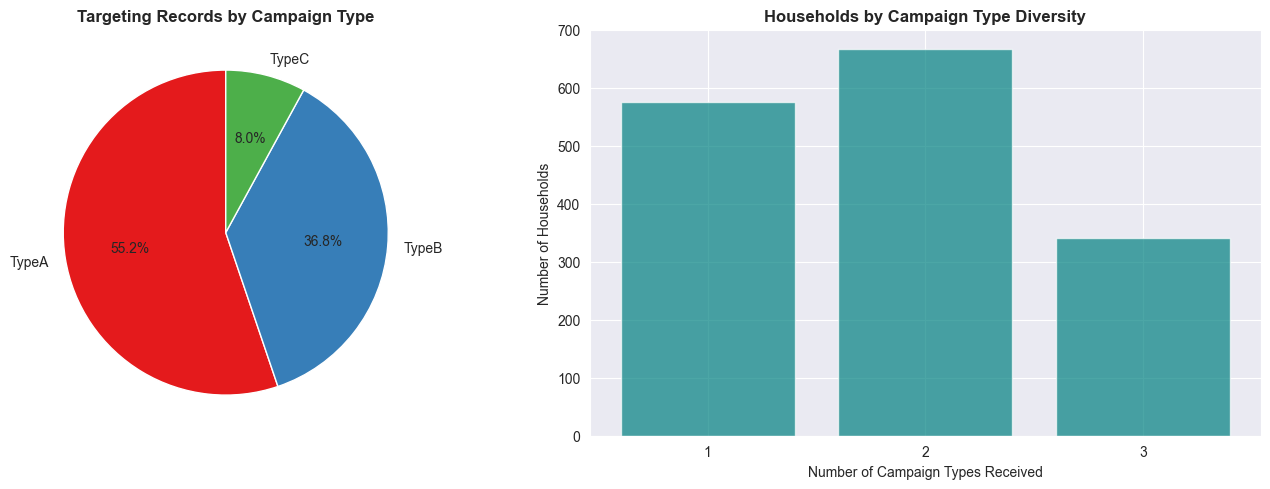

MULTI-TARGETING PATTERNS

Households receiving campaigns from:
  1 type only: 576 (36.4%)
  2 types: 667 (42.1%)
  All 3 types: 341 (21.5%)


In [14]:
# Campaign type distribution and multi-targeting patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Targeting records by campaign type
type_counts = df_campaign_table['DESCRIPTION'].value_counts()
axes[0].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', 
            colors=['#e41a1c', '#377eb8', '#4daf4a'], startangle=90)
axes[0].set_title('Targeting Records by Campaign Type', fontsize=12, fontweight='bold')

# 2) Multi-campaign households by number of campaign types
hh_type_count = hh_campaign_count['campaign_types'].apply(len)
type_dist = hh_type_count.value_counts().sort_index()
axes[1].bar(type_dist.index, type_dist.values, color='teal', alpha=0.7)
axes[1].set_xlabel('Number of Campaign Types Received')
axes[1].set_ylabel('Number of Households')
axes[1].set_title('Households by Campaign Type Diversity', fontsize=12, fontweight='bold')
axes[1].set_xticks([1, 2, 3])

plt.tight_layout()
plt.show()

print("="*60)
print("MULTI-TARGETING PATTERNS")
print("="*60)
print(f"\nHouseholds receiving campaigns from:")
print(f"  1 type only: {(hh_type_count == 1).sum():,} ({(hh_type_count == 1).mean()*100:.1f}%)")
print(f"  2 types: {(hh_type_count == 2).sum():,} ({(hh_type_count == 2).mean()*100:.1f}%)")
print(f"  All 3 types: {(hh_type_count == 3).sum():,} ({(hh_type_count == 3).mean()*100:.1f}%)")

**Summary: Campaign Targeting Analysis**
- **Targeting scale:** Varies significantly by campaign type
  - TypeA: Larger audience
  - TypeB: Most campaigns, medium audience
  - TypeC: Smaller, more targeted
- **Multi-campaign exposure:** Most households receive multiple campaigns
- **Campaign type overlap:** Many households receive campaigns from multiple types

### 4.4 Coupon Structure

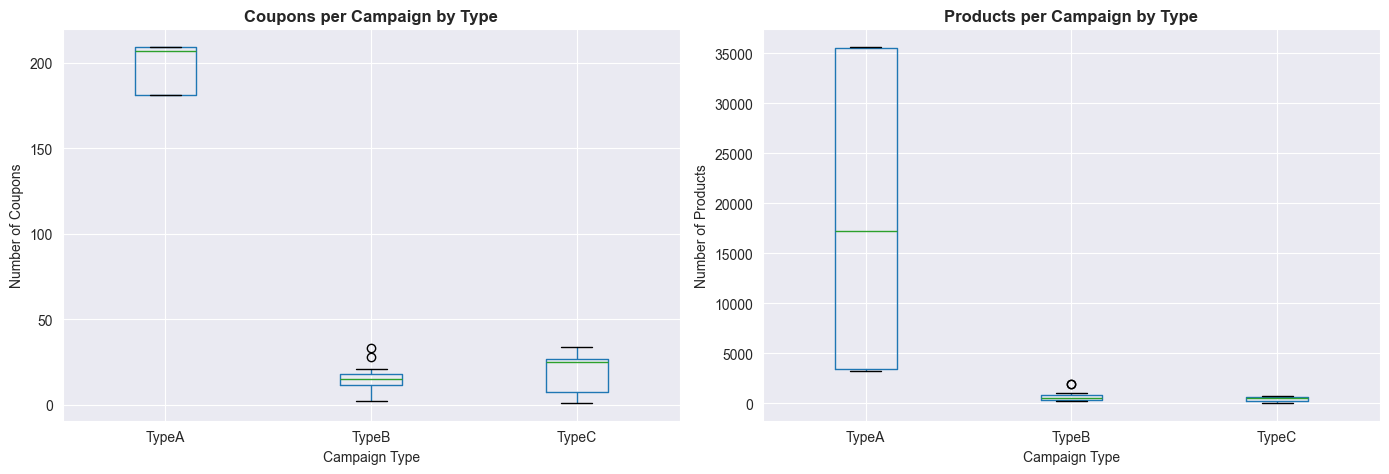

COUPON STRUCTURE BY CAMPAIGN TYPE
| DESCRIPTION   |   avg_coupons |   avg_products |   total_coupons |   total_products |
|:--------------|--------------:|---------------:|----------------:|-----------------:|
| TypeA         |         197.4 |        18981.6 |             987 |            94908 |
| TypeB         |          15.6 |          667.3 |             296 |            12678 |
| TypeC         |          19   |          422.3 |             114 |             2534 |


In [15]:
# Coupons and products per campaign
coupon_campaign = df_coupon.groupby('CAMPAIGN').agg(**{
    'n_coupons': ('COUPON_UPC', 'nunique'),
    'n_products': ('PRODUCT_ID', 'nunique')
})

# Merge with campaign type
coupon_campaign = coupon_campaign.merge(
    df_campaign_desc[['CAMPAIGN', 'DESCRIPTION']],
    on='CAMPAIGN'
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Coupons per campaign by type
coupon_campaign.boxplot(column='n_coupons', by='DESCRIPTION', ax=axes[0])
axes[0].set_title('Coupons per Campaign by Type', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Campaign Type')
axes[0].set_ylabel('Number of Coupons')
plt.suptitle('')

# 2) Products per campaign by type
coupon_campaign.boxplot(column='n_products', by='DESCRIPTION', ax=axes[1])
axes[1].set_title('Products per Campaign by Type', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Campaign Type')
axes[1].set_ylabel('Number of Products')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("="*60)
print("COUPON STRUCTURE BY CAMPAIGN TYPE")
print("="*60)
print(coupon_campaign.groupby('DESCRIPTION').agg(**{
    'avg_coupons': ('n_coupons', 'mean'),
    'avg_products': ('n_products', 'mean'),
    'total_coupons': ('n_coupons', 'sum'),
    'total_products': ('n_products', 'sum')
}).round(1).to_markdown())

**Summary: Coupon Structure**
- **Coupon distribution:** Varies by campaign type
- **Product coverage:** Number of products targeted differs by campaign type
- **Campaign type characteristics:**
  - TypeA: Larger product assortment
  - TypeB: More focused product selection
  - TypeC: Targeted promotions

### 4.5 Coupon Redemption Analysis

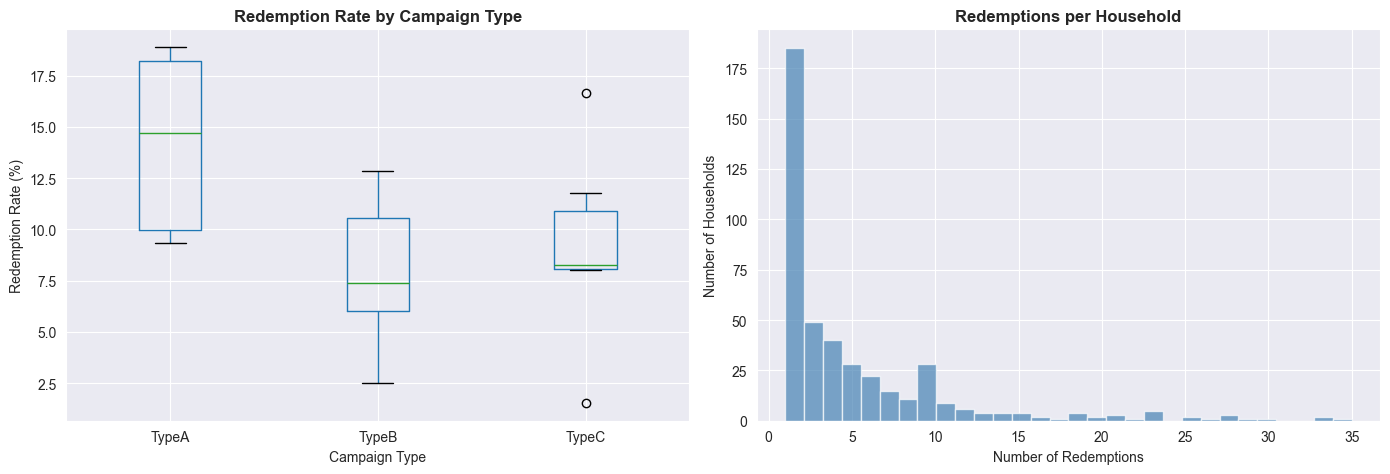

REDEMPTION METRICS

Overall redemption rate: 12.3%

Redemption rate by campaign type:
| DESCRIPTION   |   mean |   min |   max |
|:--------------|-------:|------:|------:|
| TypeA         |   14.2 |   9.3 |  18.9 |
| TypeB         |    7.8 |   2.5 |  12.8 |
| TypeC         |    9.1 |   1.5 |  16.7 |

REDEMPTION PATTERNS

Redemptions per household:
|               |   count |   mean |   std |   min |   25% |   50% |   75% |   max |
|:--------------|--------:|-------:|------:|------:|------:|------:|------:|------:|
| n_redemptions |     434 |    5.3 |   6.1 |     1 |     1 |     3 |     7 |    35 |

Households with 1 redemption: 116 (26.7%)
Households with 5+ redemptions: 160 (36.9%)


In [22]:
# Redemption rate analysis
# Merge redemption with campaign info
df_redempt_full = df_coupon_redempt.merge(
    df_campaign_desc[['CAMPAIGN', 'DESCRIPTION', 'START_DAY', 'END_DAY']],
    on='CAMPAIGN'
)

# Calculate time to redemption
df_redempt_full = df_redempt_full.assign(
    days_since_start=lambda x: x['DAY'] - x['START_DAY'],
    within_campaign=lambda x: (x['DAY'] >= x['START_DAY']) & (x['DAY'] <= x['END_DAY'])
)

# Redemption rate by campaign
targeted_hh_per_campaign = df_campaign_table.groupby('CAMPAIGN')['household_key'].nunique()
redeemed_hh_per_campaign = df_coupon_redempt.groupby('CAMPAIGN')['household_key'].nunique()

redemption_rate = (redeemed_hh_per_campaign / targeted_hh_per_campaign * 100).fillna(0)
redemption_rate_df = redemption_rate.reset_index()
redemption_rate_df.columns = ['CAMPAIGN', 'redemption_rate']
redemption_rate_df = redemption_rate_df.merge(df_campaign_desc[['CAMPAIGN', 'DESCRIPTION']])

# Redemptions per household
hh_redemption_count = df_coupon_redempt.groupby('household_key').agg(**{
    'n_redemptions': ('COUPON_UPC', 'count'),
    'n_campaigns': ('CAMPAIGN', 'nunique'),
    'n_coupons': ('COUPON_UPC', 'nunique')
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Redemption rate by campaign type (boxplot)
redemption_rate_df.boxplot(column='redemption_rate', by='DESCRIPTION', ax=axes[0])
axes[0].set_title('Redemption Rate by Campaign Type', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Campaign Type')
axes[0].set_ylabel('Redemption Rate (%)')
plt.suptitle('')

# 2) Redemptions per household
axes[1].hist(hh_redemption_count['n_redemptions'].clip(upper=50), bins=30, 
             color='steelblue', alpha=0.7, edgecolor='white')
axes[1].set_title('Redemptions per Household', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Redemptions')
axes[1].set_ylabel('Number of Households')

plt.tight_layout()
plt.show()

print("="*60)
print("REDEMPTION METRICS")
print("="*60)
print(f"\nOverall redemption rate: {redeemed_hh_per_campaign.sum() / targeted_hh_per_campaign.sum() * 100:.1f}%")
print(f"\nRedemption rate by campaign type:")
print(redemption_rate_df.groupby('DESCRIPTION')['redemption_rate'].agg(['mean', 'min', 'max']).round(1).to_markdown())

print("\n" + "="*60)
print("REDEMPTION PATTERNS")
print("="*60)
print(f"\nRedemptions per household:")
print(hh_redemption_count['n_redemptions'].describe().round(1).to_frame().T.to_markdown())
print(f"\nHouseholds with 1 redemption: {(hh_redemption_count['n_redemptions'] == 1).sum():,} ({(hh_redemption_count['n_redemptions'] == 1).mean()*100:.1f}%)")
print(f"Households with 5+ redemptions: {(hh_redemption_count['n_redemptions'] >= 5).sum():,} ({(hh_redemption_count['n_redemptions'] >= 5).mean()*100:.1f}%)")

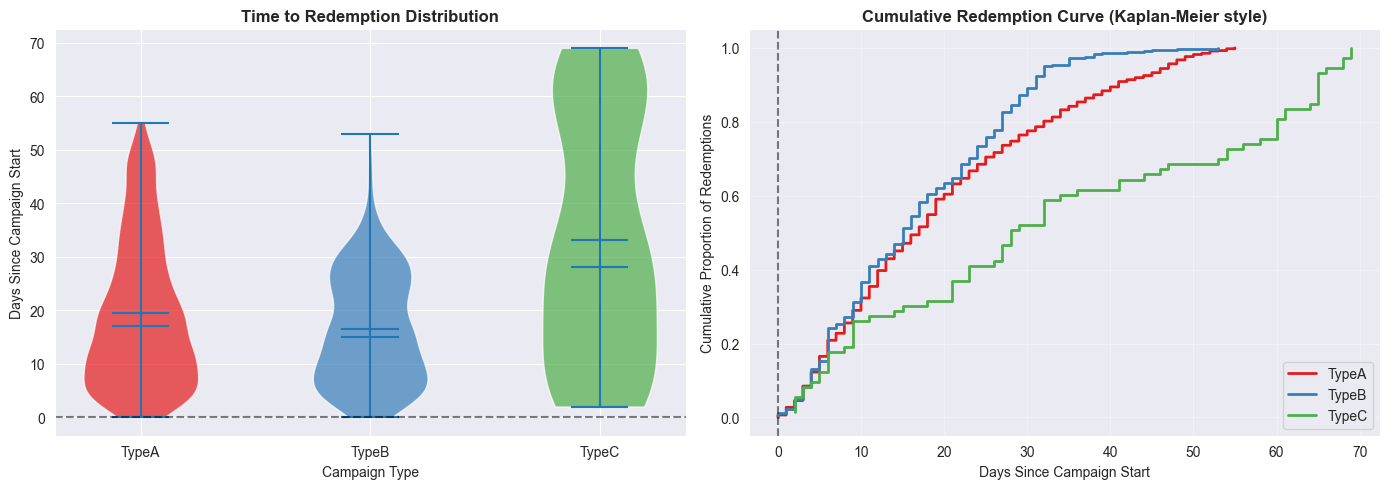

TIME TO REDEMPTION BY CAMPAIGN TYPE
| DESCRIPTION   |   count |   mean |   median |   std |   min |   max |
|:--------------|--------:|-------:|---------:|------:|------:|------:|
| TypeA         |    1791 |   19.5 |       17 |  13.8 |     0 |    55 |
| TypeB         |     454 |   16.5 |       15 |  10.5 |     0 |    53 |
| TypeC         |      73 |   33.1 |       28 |  22.9 |     2 |    69 |

Redemptions within campaign period: 2,318 (100.0%)


In [23]:
# Time to redemption analysis by campaign type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'TypeA': '#e41a1c', 'TypeB': '#377eb8', 'TypeC': '#4daf4a'}

# 1) Violin plot: Time to redemption distribution by campaign type
violin_data = [df_redempt_full[df_redempt_full['DESCRIPTION'] == t]['days_since_start'].values 
               for t in ['TypeA', 'TypeB', 'TypeC']]
parts = axes[0].violinplot(violin_data, positions=[1, 2, 3], showmeans=True, showmedians=True)
for i, (pc, ctype) in enumerate(zip(parts['bodies'], ['TypeA', 'TypeB', 'TypeC'])):
    pc.set_facecolor(colors[ctype])
    pc.set_alpha(0.7)
axes[0].axhline(0, color='black', linestyle='--', alpha=0.5)
axes[0].set_xticks([1, 2, 3])
axes[0].set_xticklabels(['TypeA', 'TypeB', 'TypeC'])
axes[0].set_xlabel('Campaign Type')
axes[0].set_ylabel('Days Since Campaign Start')
axes[0].set_title('Time to Redemption Distribution', fontsize=12, fontweight='bold')

# 2) Kaplan-Meier style: Cumulative redemption curve
for ctype in ['TypeA', 'TypeB', 'TypeC']:
    subset = df_redempt_full[df_redempt_full['DESCRIPTION'] == ctype]['days_since_start'].sort_values()
    cumulative = np.arange(1, len(subset) + 1) / len(subset)
    axes[1].step(subset, cumulative, where='post', label=ctype, color=colors[ctype], linewidth=2)
axes[1].axvline(0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Days Since Campaign Start')
axes[1].set_ylabel('Cumulative Proportion of Redemptions')
axes[1].set_title('Cumulative Redemption Curve (Kaplan-Meier style)', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("="*60)
print("TIME TO REDEMPTION BY CAMPAIGN TYPE")
print("="*60)
time_to_redemption_stats = df_redempt_full.groupby('DESCRIPTION')['days_since_start'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(1)
print(time_to_redemption_stats.to_markdown())

print(f"\nRedemptions within campaign period: {df_redempt_full['within_campaign'].sum():,} ({df_redempt_full['within_campaign'].mean()*100:.1f}%)")

**Summary: Coupon Redemption Analysis**
- **Redemption rate varies by campaign type:**
  - **TypeA highest redemption** - personalized coupons (16 coupons selected from pool based on customer's prior purchase behavior)
  - **TypeB/TypeC lower** - all participating customers receive the same full set of coupons
- **Why TypeA has higher redemption:** Personalization based on purchase history increases relevance → higher likelihood of use
- **Time to redemption:** Most redemptions occur within campaign period
- **Redemption intensity:** Wide variation - some households redeem many coupons
- **Timing patterns:** Majority of redemptions within campaign window

### 4.6 Demographic Comparison

In [ ]:
# Demographic column mapping (consistent with exploration_1)
column_mapping = {
    'classification_1': 'AGE_GRP',
    'classification_2': 'MARITAL',
    'classification_3': 'INCOME_GRP',
    'classification_4': 'HOUSEHOLD_SIZE',
    'classification_5': 'HOUSEHOLD_COMPOSITION',
}

df_demo = df_demo.rename(columns=column_mapping)
tableone_cols = ['AGE_GRP', 'MARITAL', 'INCOME_GRP', 'HOMEOWNER_DESC', 'HOUSEHOLD_SIZE', 'KID_CATEGORY_DESC']

# Analyze targeting by campaign type
# TypeA: personalized targeting → expect demographic differences
# TypeB/TypeC: uniform distribution → expect no demographic differences (if randomized)

print("="*60)
print("DEMOGRAPHIC ANALYSIS BY CAMPAIGN TYPE")
print("="*60)
print("\nHypothesis:")
print("  - TypeA: Personalized (16 coupons selected per customer) → demographic differences expected")
print("  - TypeB/TypeC: Uniform (all customers get same coupons) → no demographic differences expected")

for ctype in ['TypeA', 'TypeB', 'TypeC']:
    # Get households targeted by this campaign type
    targeted_hh_type = df_campaign_table[df_campaign_table['DESCRIPTION'] == ctype]['household_key'].unique()
    
    df_demo_analysis = df_demo.assign(
        is_targeted=lambda x, t=targeted_hh_type: x['household_key'].isin(t).astype(int)
    )
    
    n_targeted = df_demo_analysis['is_targeted'].sum()
    n_not_targeted = (df_demo_analysis['is_targeted'] == 0).sum()
    
    print(f"\n{'='*60}")
    print(f"{ctype}: Targeted vs Non-targeted")
    print(f"{'='*60}")
    print(f"Targeted: {n_targeted} ({n_targeted/len(df_demo_analysis)*100:.1f}%)")
    print(f"Non-targeted: {n_not_targeted} ({n_not_targeted/len(df_demo_analysis)*100:.1f}%)")
    
    result = filter_tableone(
        compute_tableone(
            df_demo_analysis, 'is_targeted', tableone_cols,
            categorical=tableone_cols, expand_categorical=True, effect_size=False
        ), p_threshold=0.05
    )
    
    if len(result) > 0:
        print(f"\nSignificant differences (p < 0.05):")
        print(result.to_markdown(index=False))
    else:
        print(f"\nNo significant demographic differences found (p < 0.05)")

In [27]:
# Redeemers vs Non-redeemers (among targeted households)
redeemed_hh = df_coupon_redempt['household_key'].unique()

df_demo_targeted = df_demo[df_demo['is_targeted'] == 1].assign(
    is_redeemer=lambda x: x['household_key'].isin(redeemed_hh).astype(int)
)

print("="*60)
print("REDEEMERS vs NON-REDEEMERS (among targeted)")
print("="*60)
print(f"\nRedeemers: {df_demo_targeted['is_redeemer'].sum()} ({df_demo_targeted['is_redeemer'].mean()*100:.1f}%)")
print(f"Non-redeemers: {(df_demo_targeted['is_redeemer'] == 0).sum()} ({(df_demo_targeted['is_redeemer'] == 0).mean()*100:.1f}%)")

result = filter_tableone(
    compute_tableone(
        df_demo_targeted, 'is_redeemer', tableone_cols,
        categorical=tableone_cols, expand_categorical=True, effect_size=False
    ), p_threshold=0.1
)

print("\n" + "="*60)
print("SIGNIFICANT DEMOGRAPHIC DIFFERENCES (p < 0.1)")
print("="*60)
if len(result) > 0:
    print(result.to_markdown(index=False))
else:
    print("No significant differences found.")

REDEEMERS vs NON-REDEEMERS (among targeted)

Redeemers: 311 (40.9%)
Non-redeemers: 449 (59.1%)

SIGNIFICANT DEMOGRAPHIC DIFFERENCES (p < 0.1)
| Variable       | Category        | Overall     | 0 (n=449)   | 1 (n=311)   | Test        | Statistic   | P-value   |
|:---------------|:----------------|:------------|:------------|:------------|:------------|:------------|:----------|
| AGE_GRP        | Age Group1      | 45 (5.9%)   | 36 (8.0%)   | 9 (2.9%)    | Chi-squared | 10.96       | 0.05      |
|                | Age Group2      | 130 (17.1%) | 78 (17.4%)  | 52 (16.7%)  |             |             |           |
|                | Age Group3      | 187 (24.6%) | 109 (24.3%) | 78 (25.1%)  |             |             |           |
|                | Age Group4      | 271 (35.7%) | 148 (33.0%) | 123 (39.5%) |             |             |           |
|                | Age Group5      | 59 (7.8%)   | 35 (7.8%)   | 24 (7.7%)   |             |             |           |
|                | Age Gr

**Summary: Demographic Comparison**

**Targeting by Campaign Type:**
- **TypeA** (personalized): Demographic differences expected due to behavior-based coupon selection
- **TypeB/TypeC** (uniform coupons): Despite uniform coupon distribution, demographic differences exist in targeting
  - Implication: Targeting itself is not fully randomized across demographics
  - Need to control for demographics when estimating causal effects

**Redeemers vs Non-redeemers:**
- Significant differences in AGE_GRP, MARITAL, INCOME_GRP, HOMEOWNER_DESC
- These demographic factors are potential confounders/effect modifiers in causal analysis

### Key Takeaways: Campaign Analysis

**Campaign Overview**
- 30 campaigns across 3 types: TypeA (5), TypeB (19), TypeC (6)
- Campaign period: Day 224-719, within transaction period Day 1-711
- Duration varies by type: TypeA longest (~47 days avg), TypeB medium (~38 days), TypeC variable (~75 days)

**Targeting Patterns**
- 1,584 unique households targeted (63% of total 2,500)
- High concentration: most households receive multiple campaigns
- TypeB campaigns most frequent, TypeA targets larger audiences

**Coupon Structure**
- 1,135 unique coupons covering 44,133 products
- Coupon-product coverage varies significantly by campaign type

**Redemption Effectiveness**
- Overall redemption rate: ~27% of targeted households
- 434 households redeemed at least once (27% of targeted)
- Wide variation in redemption intensity per household

**Demographic Insights**
- Targeted vs Non-targeted: Significant differences in HOUSEHOLD_SIZE and KID_CATEGORY_DESC
- Redeemers vs Non-redeemers: Significant differences in AGE_GRP, MARITAL, INCOME_GRP, HOMEOWNER_DESC
- These demographic factors are potential effect modifiers for causal analysis